# Antiderivative SpectralSVR (Proof of concept)

In [1]:
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from skripsi_program import (
    SpectralSVR,
    FourierBasis,
    StandardScaler,
    Antiderivative,
    to_real_coeff
)
from notebooks.utils import save_to_pgf

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    }
)

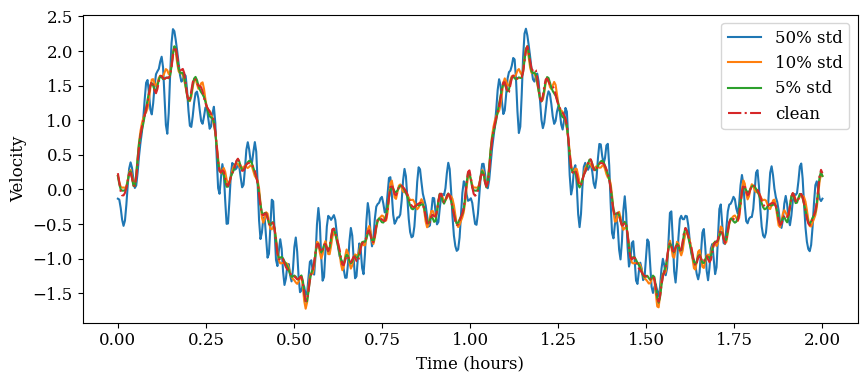

(100,)

In [6]:
# Set seed
generator = torch.Generator().manual_seed(42)
# domain
domain = slice(0, 2, 500)
# Generate functions/data
n_coeffs = 5000
modes = 100
u0 = 0  # integration constant
problem = Antiderivative()
u_clean, f_clean = problem.generate(
    FourierBasis, n_coeffs, modes, u0, generator=generator
)


# Add noise 1%
u_5 = u_clean.perturb(std_ratio=0.05, generator=generator)
f_5 = f_clean.perturb(std_ratio=0.05, generator=generator)
# Add noise 10%
u_10 = u_clean.perturb(std_ratio=0.10, generator=generator)
f_10 = f_clean.perturb(std_ratio=0.10, generator=generator)
# Add noise 50%
u_50 = u_clean.perturb(std_ratio=0.50, generator=generator)
f_50 = f_clean.perturb(std_ratio=0.50, generator=generator)

# Interpolate f & u
t = FourierBasis.grid(res=domain)
f = f_50(t)
f = f.real

u = u_50(t)
u = u.real

plt.figure(figsize=(10, 4))
u_50.plot(res=domain)
u_10.plot(res=domain)
u_5.plot(res=domain)
u_clean.plot(res=domain, linestyle="-.")
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
plt.legend(["50% std", "10% std", "5% std", "clean"], loc="upper right")
save_to_pgf("clean_perturbed_solution.pgf")
plt.show()
f_50.modes

In [7]:
f_clean.coeff[0]

tensor([  -0.0000+0.0000j,  272.5070+210.3337j,  127.3806-297.7656j,
          95.9428-174.5910j,   -6.0907-226.9342j, -106.3680+233.1646j,
         -55.5049-198.5000j, -102.9380-79.1154j, -108.7302+107.8261j,
         232.2587-22.5705j,  -70.3426+62.1673j, -107.2159+152.4971j,
         113.2503+237.6756j,  180.8955+183.3419j,   86.3330+188.7604j,
         -32.7566+5.9057j,  -35.5781+121.6024j, -195.8224-123.2114j,
         -31.5887+242.8716j,   45.0965-60.0360j,   43.2355-109.5439j,
        -220.2740+140.8042j, -124.4205-85.0143j, -180.1922+300.2072j,
        -174.6063-69.0014j, -129.2341-93.0747j,   11.0342+74.3606j,
         -69.0125+168.4850j, -115.1181-104.0851j, -198.4492+5.0917j,
          -8.9770+95.5464j,  -13.8320+260.8650j, -167.5189+195.6634j,
         204.3728+121.1150j,  313.6833+73.9868j,   49.0232-27.9069j,
        -149.1414+180.7359j,  -24.3514+74.0749j,    8.0075+60.2874j,
          81.3180-90.7535j, -312.0319-106.1796j,    1.5370-47.9054j,
        -189.6007-82.7839j,

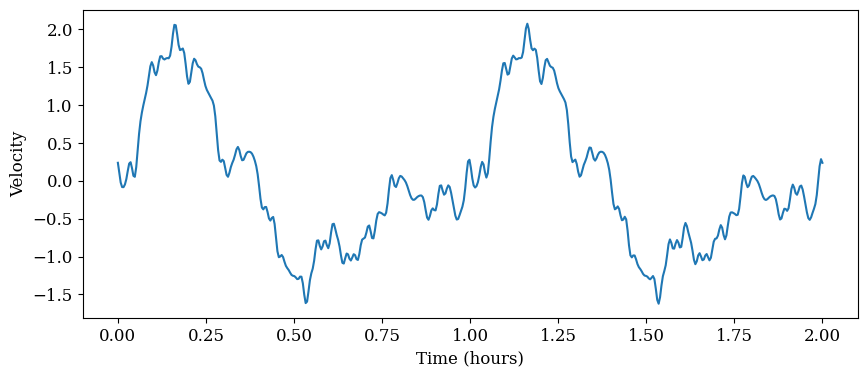

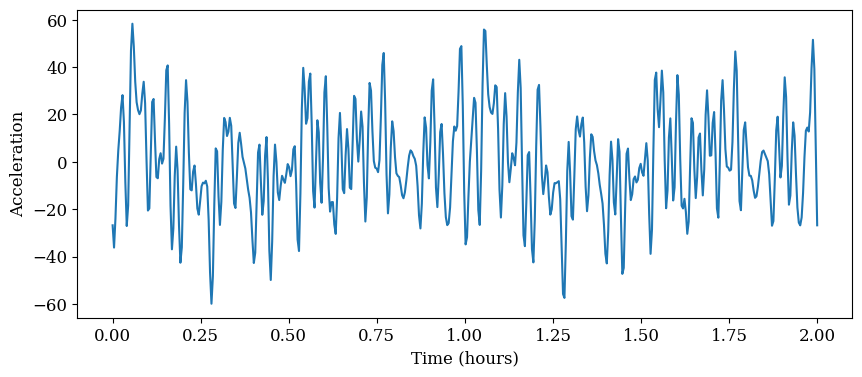

In [8]:
plt.figure(figsize=(10, 4))
u_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
save_to_pgf("antiderivative_clean_0.pgf")
plt.figure(figsize=(10, 4))
f_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Acceleration")
save_to_pgf("derivative_clean_0.pgf")

In [6]:
# Train-test split
# df = TensorDataset(f, u, u_fourier.coeff)
df = TensorDataset(f_10.coeff, u, u_10.coeff)
df_train, df_test = random_split(df, (0.8, 0.2), generator=generator)  # Scale inputs based on training inputs
f_train, u_train, u_coeff_train = df_train[:]
scaler = StandardScaler().fit(f_train)
f_train = scaler.transform(f_train)
f_test, u_test, u_coeff_test = df_test[:]
f_test = scaler.transform(f_test)

In [7]:
# Train svm
periods = [1.0]
model = SpectralSVR(
    FourierBasis(periods=periods),
    C=1.0,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    verbose=None,
)
model.train(f_train, u_coeff_train)

In [8]:
model.svr.kernel_params.get("sigma")

tensor(4.4727, device='cuda:0')

In [9]:
# Test
model.test(f_test, u_coeff_test), model.test(f_test, u_clean.coeff[df_test.indices])

({'spectral': {'mse': 0.039172980934381485,
   'rmse': 0.19792164862155914,
   'mae': 0.14180944859981537,
   'r2': 0.9113022089004517,
   'smape': 0.4505499005317688,
   'rse': 0.08869855105876923,
   'rrse': 0.22800812125205994,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.007653410546481609,
   'rmse': 0.08748377114534378,
   'mae': 0.06840600073337555,
   'r2': 0.9739546179771423,
   'smape': 0.3396867513656616,
   'rse': 0.026045355945825577,
   'rrse': 0.1613757312297821,
   'pred_nan_sum': 0}},
 {'spectral': {'mse': 0.023749254643917084,
   'rmse': 0.154107928276062,
   'mae': 0.09601500630378723,
   'r2': 0.9353901147842407,
   'smape': 0.3404603898525238,
   'rse': 163765.828125,
   'rrse': 90.60371398925781,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.004715869668871164,
   'rmse': 0.06867218762636185,
   'mae': 0.05223560705780983,
   'r2': 0.9837974309921265,
   'smape': 0.2652144432067871,
   'rse': 0.01620250754058361,
   'rrse': 0.12726883590221405,
   '

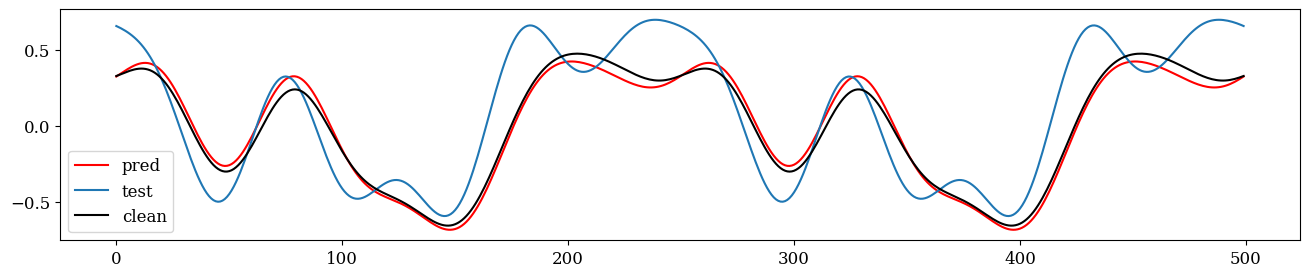

In [10]:
u_pred = model.forward(f_test, t, periods=periods).real
plt.figure(figsize=(16, 3))
# plt.plot(f_fourier[df_test.indices[0]](s).real[0], color="k")
i = 5
plt.plot(u_pred[i], color="r")
plt.plot(u_test[i])
plt.plot(u_clean[df_test.indices[i]](t)[0].real, color="k")
plt.legend(["pred","test","clean"])

(torch.Size([4000, 20]),
 torch.return_types.sort(
 values=tensor([-4.0274, -3.8019, -3.6800,  ...,  3.2136,  3.3410,  3.5299]),
 indices=tensor([2279, 1322, 1583,  ...,  531,  515, 2333])))

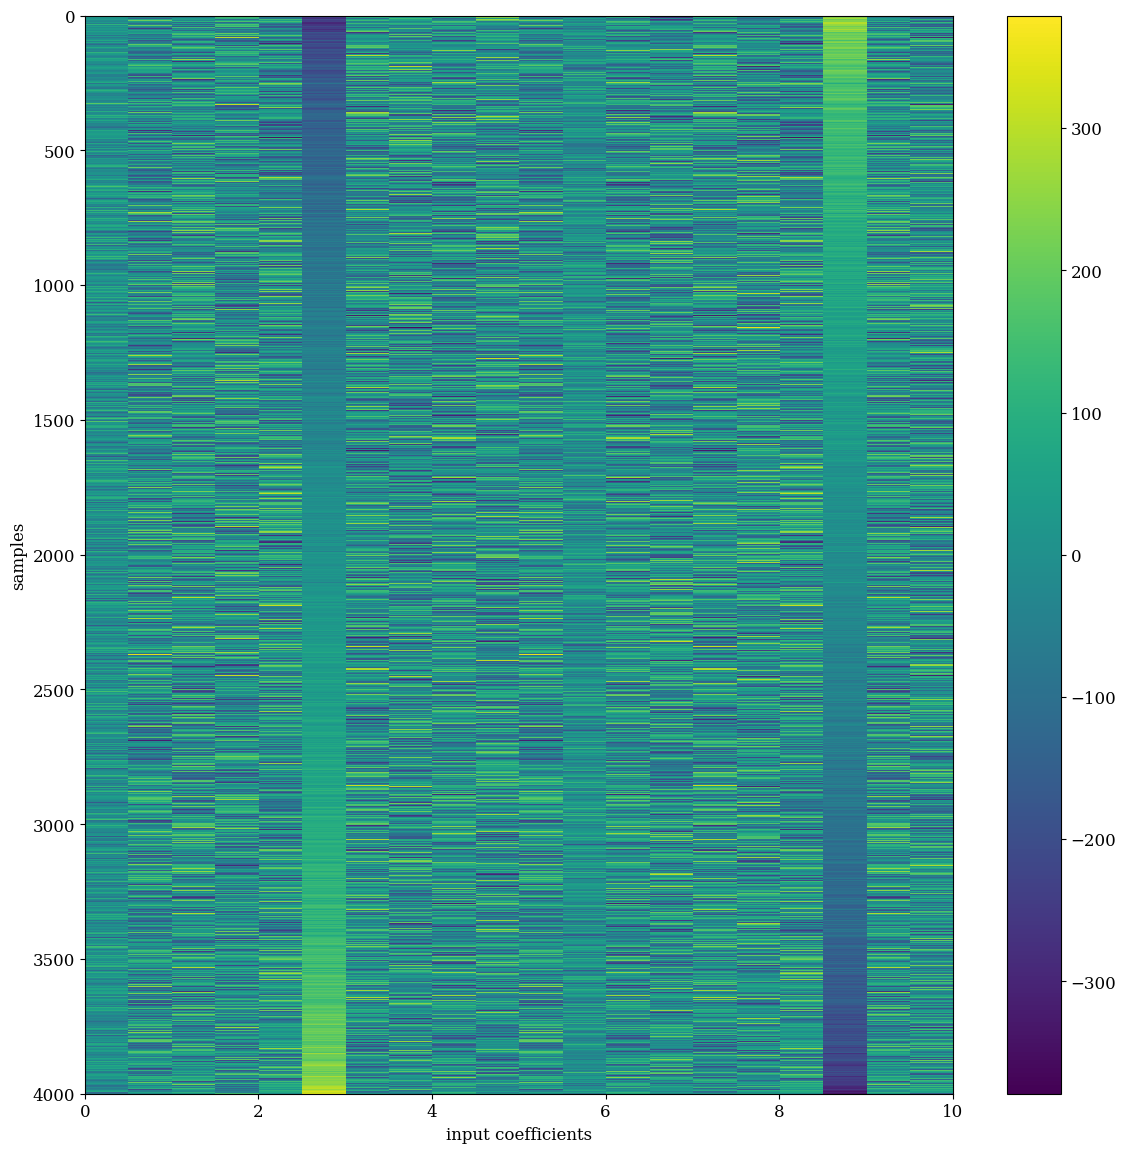

In [11]:
corr = model.svr.get_correlation_image().cpu()
sorted = u_coeff_train.real[:,2].sort()
plt.figure(figsize=(14, 14))
plt.imshow(corr[sorted.indices.cpu(), :], interpolation="none", aspect="auto",extent=(0,modes,corr.shape[0],0))
plt.ylabel("samples")
plt.xlabel("input coefficients")
plt.colorbar()
corr.shape, sorted


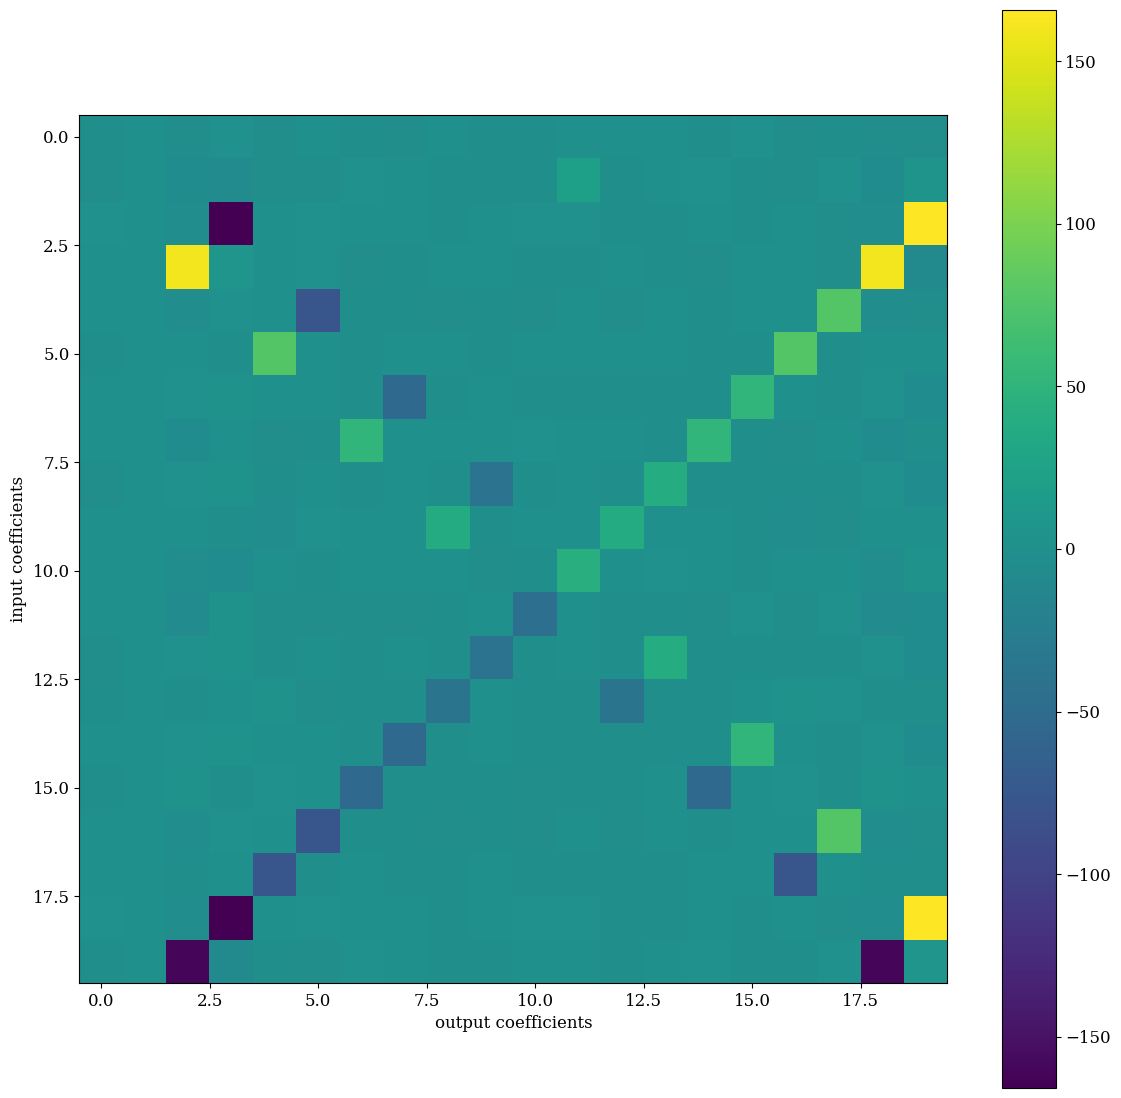

In [12]:
p_mat = model.svr.get_p_matrix().cpu()
plt.figure(figsize=(14,14))
plt.imshow(p_mat[:,:], interpolation="none", aspect="equal")
# plt.imshow(p_mat[:,2][:,None], interpolation="none", aspect="auto", extent=(0,10,0,10))
plt.colorbar()
plt.xlabel("output coefficients")
plt.ylabel("input coefficients")
plt.show()

In [26]:
u_clean[0].coeff, u_clean[0].grad().coeff

(tensor([[ 0.0000+0.0000j,  3.3476-4.3371j, -2.3695-1.0137j, -0.9262-0.5090j,
          -0.9029+0.0242j,  0.7960-0.5727j, -0.9029-0.0242j, -0.9262+0.5090j,
          -2.3695+1.0137j,  3.3476+4.3371j]]),
 tensor([[  0.0000+0.0000j,  27.2507+21.0334j,  12.7381-29.7766j,
            9.5943-17.4591j,  -0.6091-22.6934j, -17.9934-25.0071j,
           -0.6091+22.6934j,   9.5943+17.4591j,  12.7381+29.7766j,
           27.2507-21.0334j]]))

In [31]:
multiplier = 2 * torch.pi * 1j * FourierBasis.wave_number(model.modes[0]).T
multiplier, u_clean[0].coeff * multiplier


(tensor([[0.+0.0000j, 0.+6.2832j, 0.+12.5664j, 0.+18.8496j, 0.+25.1327j, -0.-31.4159j,
          -0.-25.1327j, -0.-18.8496j, -0.-12.5664j, -0.-6.2832j]]),
 tensor([[  0.0000+0.0000j,  27.2507+21.0334j,  12.7381-29.7766j,
            9.5943-17.4591j,  -0.6091-22.6934j, -17.9934-25.0071j,
           -0.6091+22.6934j,   9.5943+17.4591j,  12.7381+29.7766j,
           27.2507-21.0334j]]))

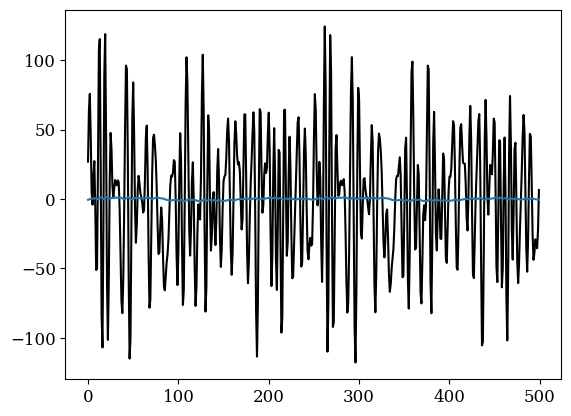

In [12]:
u_grad = torch.gradient(u_test[0], edge_order=2, spacing=t[1].sub(t[0]).item())[0]
plt.plot(u_grad, color="k")
plt.plot(u_test[0])
# plt.plot(scaler.inverse(f_test[:1])[0], color="r", linestyle="-")


In [28]:
# Test CPU
model = SpectralSVR(
    FourierBasis(periods=periods), C=1.0, device=torch.device("cpu"), verbose=None
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)


70.4 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
84.7 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
# Test GPU
model = SpectralSVR(
    FourierBasis(periods=periods), C=1.0, device=torch.device("cuda:0"), verbose=None
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)


43.1 ms ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
59.7 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
